# Import packages and data 

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import scipy.stats
import anndata
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from scipy import sparse
matplotlib_axes_logger.setLevel('ERROR')
import warnings
warnings.filterwarnings('ignore')

/Users/b8058304/.pyenv/versions/3.6.4/envs/py36/lib/python3.6/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
# Set up the plot config for viewing the annotation clearly.
sc.settings.set_figure_params(dpi=120, dpi_save=1000)
sc.logging.print_versions()

scanpy==1.4.4 anndata==0.7.1 umap==0.3.10 numpy==1.17.1 scipy==1.4.1 pandas==1.0.5 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1


# Load FBM transformed dataset

In [4]:
adata = sc.read("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs/data/fig1c_fbm_scaled_gex_updated_dr_20200718.h5ad")

In [5]:
cell_numbers = adata.obs.groupby(["broad_fig1_cell.labels"]).apply(len)
cell_numbers

broad_fig1_cell.labels
HSC_MPP          3800
erythroid       26591
MK               2701
B_lineage       28613
DC               2460
eo/baso/mast     1112
neutrophil      10756
monocyte        20453
T_NK             1350
stroma           6726
dtype: int64

# Add metadata for slightly more detailed groupings

In [6]:
annot = pd.read_csv("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs/resources_for_pipelines/fbm_broad_annots_20200717.csv")

In [7]:
refined_annot = annot["cell.labels"].tolist()
refined_annot

['adipo-CAR',
 'arteriolar fibroblast',
 'basophil',
 'CD14 monocyte',
 'CD4 T cell',
 'CD56 bright NK',
 'CD8 T cell',
 'chondrocyte',
 'CMP',
 'DC precursor',
 'DC1',
 'DC2',
 'DC3',
 'early erythroid',
 'early MK',
 'early osteoblast',
 'erythroid macrophage',
 'ELP',
 'endosteal fibroblast',
 'eo/baso/mast precursor',
 'eosinophil',
 'GMP',
 'HSC',
 'ILC precursor',
 'immature B cell',
 'immature EC',
 'late erythroid',
 'mast cell',
 'mature NK',
 'MEMP',
 'MEP',
 'mid erythroid',
 'MK',
 'promonocyte',
 'monocytoid macrophage',
 'LMPP',
 'MPP myeloid',
 'muscle',
 'muscle stem cell',
 'myelocyte',
 'myeloid DC progenitor',
 'myofibroblast',
 'naive B cell',
 'MOP',
 'neutrophil',
 'NK T cell',
 'NK progenitor',
 'osteoblast',
 'osteoblast precursor',
 'osteochondral precursor',
 'osteoclast',
 'pDC',
 'pDC progenitor',
 'pre B progenitor',
 'pre pro B progenitor',
 'pro B progenitor',
 'proliferating EC',
 'promyelocyte',
 'schwann cells',
 'sinusoidal EC',
 'stromal macrophage',

In [8]:
broad_annot = annot["broad_figS1_cell.labels"].tolist()
broad_annot

['stroma',
 'stroma',
 'basophil',
 'CD14 monocyte',
 'T_NK',
 'T_NK',
 'T_NK',
 'stroma',
 'HSC_MPP',
 'DC_other',
 'DC1',
 'DC2',
 'DC_other',
 'erythroid',
 'MK',
 'stroma',
 'stroma',
 'HSC_MPP',
 'stroma',
 'HSC_MPP',
 'eosinophil',
 'HSC_MPP',
 'HSC_MPP',
 'T_NK',
 'B_lineage',
 'stroma',
 'erythroid',
 'mast cell',
 'T_NK',
 'HSC_MPP',
 'HSC_MPP',
 'erythroid',
 'MK',
 'promonocyte',
 'stroma',
 'HSC_MPP',
 'HSC_MPP',
 'stroma',
 'stroma',
 'myelocyte',
 'HSC_MPP',
 'stroma',
 'B_lineage',
 'promonocyte',
 'neutrophil',
 'T_NK',
 'T_NK',
 'stroma',
 'stroma',
 'stroma',
 'stroma',
 'pDC',
 'HSC_MPP',
 'B_lineage',
 'B_lineage',
 'B_lineage',
 'stroma',
 'promyelocyte',
 'stroma',
 'stroma',
 'stroma',
 'DC_other',
 'stroma',
 'T_NK']

In [9]:
adata.obs["broad_figS1_cell.labels"] = adata.obs["cell.labels"].replace(refined_annot, broad_annot)

In [10]:
adata.obs["broad_figS1_cell.labels"] = adata.obs["broad_figS1_cell.labels"].astype('category')
adata.obs["broad_figS1_cell.labels"].cat.categories

Index(['B_lineage', 'CD14 monocyte', 'DC1', 'DC2', 'DC_other', 'HSC_MPP', 'MK', 'T_NK', 'basophil', 'eosinophil', 'erythroid', 'mast cell', 'myelocyte', 'neutrophil', 'pDC', 'promonocyte', 'promyelocyte', 'stroma'], dtype='object')

# Run the dotplots

In [11]:
genes = ['PTPRC', 
'IL3RA',
'HLA-DRA',
'CD34',
'KIT',
'IL5RA',
'CD79A',
'CD14',
'MSR1',
'CLEC9A',
'CD1C',
'CD52',
'ITGAM',
'CEACAM8']

In [12]:
adata.obs["broad_figS1_cell.labels"] = adata.obs["broad_figS1_cell.labels"].cat.reorder_categories(['erythroid', 
                'MK', 
                'stroma', 'basophil', 'pDC', 'HSC_MPP', 'mast cell', 'eosinophil', 'B_lineage', 'CD14 monocyte', 
                'promonocyte', 'DC1', 'DC2', 'DC_other', 'T_NK', 'neutrophil', 'myelocyte', 'promyelocyte'])

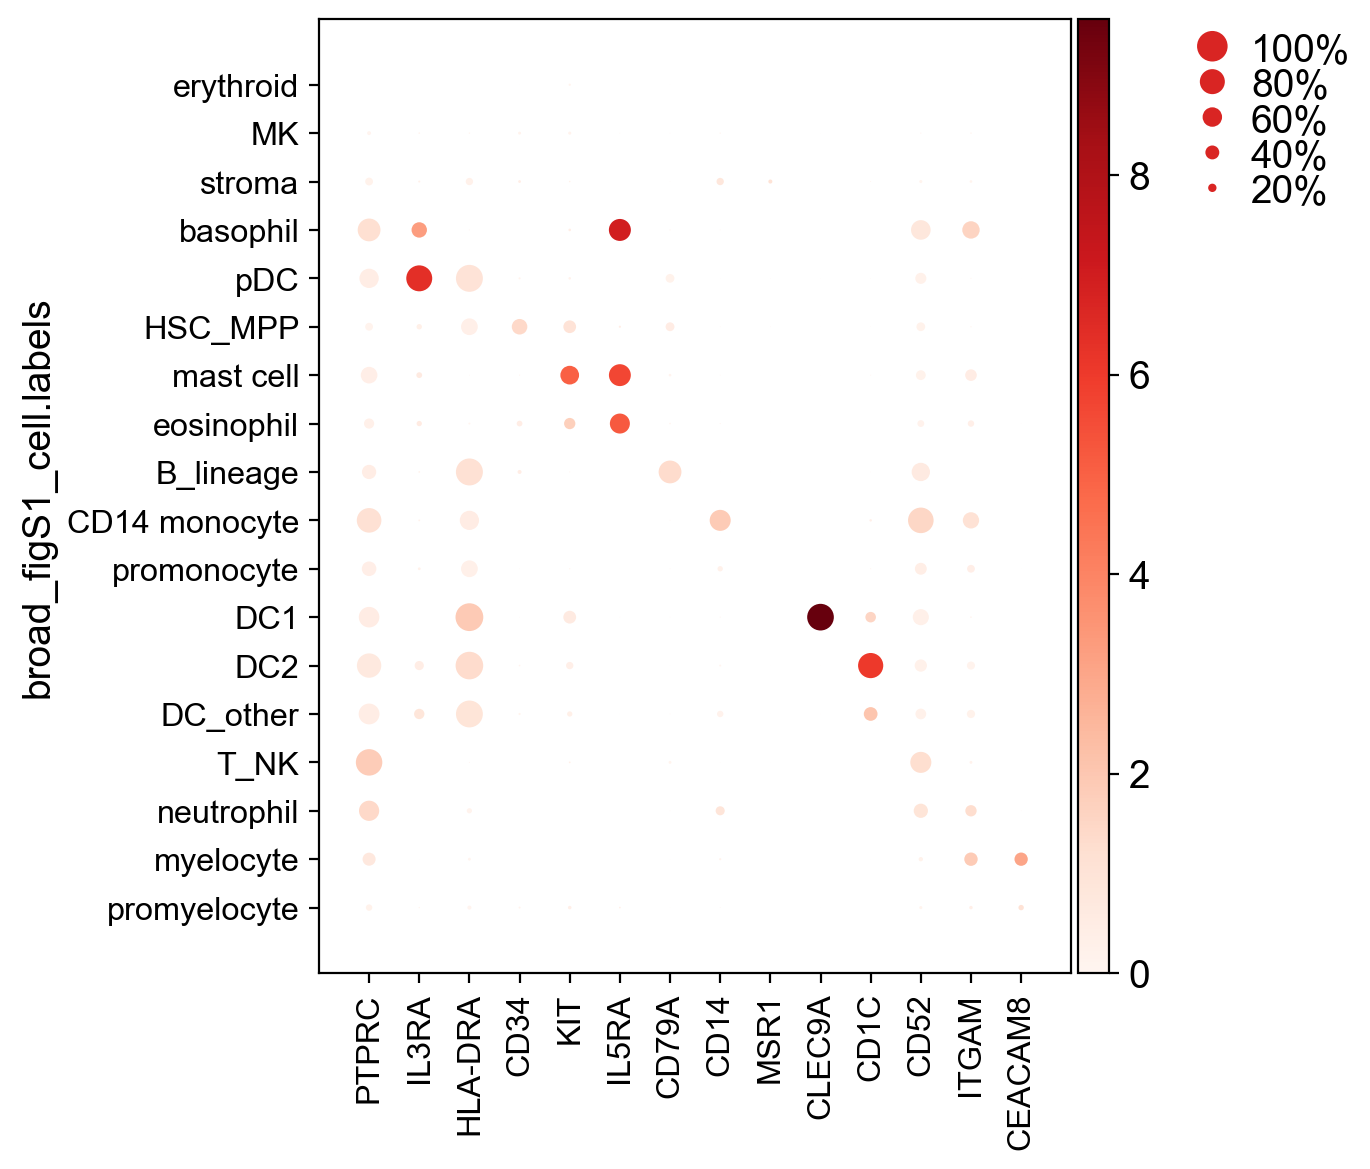

GridSpec(2, 5, height_ratios=[0, 10.5], width_ratios=[4.8999999999999995, 0, 0.2, 0.5, 0.25])

In [13]:
sc.settings.set_figure_params(dpi=100, dpi_save=1000)
sc.pl.dotplot(adata, var_names=genes, save="figs1b_overall_broad_dotplot_20200718.pdf", 
              groupby="broad_figS1_cell.labels", use_raw=False)